# **IMPORTS**

First, we declare the imports for the whole notebook.

In [11]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from PIL import Image
import copy

Here we declare some constants throughout the notebook.

In [12]:
IMAGES_PATH = "Tennis Player Actions Dataset for Human Pose Estimation/images"
DATA_SPLIT = [0.8, 0.1, 0.1]  # Train, Validation, Test
BATCH_SIZE = 32 
MAX_DEGREES = 15
IMG_SIZE = (240, 240)
SEED = 42

# Precomputed with a separate script
MEAN = [126.7874, 129.6748, 120.0113]
STD = [58.5588, 57.8795, 59.8400]

# Use GPU if available
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
DEVICE

device(type='cuda')

Now, we will import the actions dataset. 

In [13]:
full_dataset = datasets.ImageFolder(root=IMAGES_PATH)
print(full_dataset.classes)

['backhand', 'forehand', 'ready_position', 'serve']


# **EDA & PREPROCESSING**

Now we will explore the data we are working with.

In [14]:
label_to_idx = full_dataset.class_to_idx
print(f"Number of images: {len(full_dataset.samples)}")
print(f"Number of classes: {len(label_to_idx)}")

Number of images: 2000
Number of classes: 4


We have 2000 images of 4 classes, with a small search we can see that we have 500 images of each class.

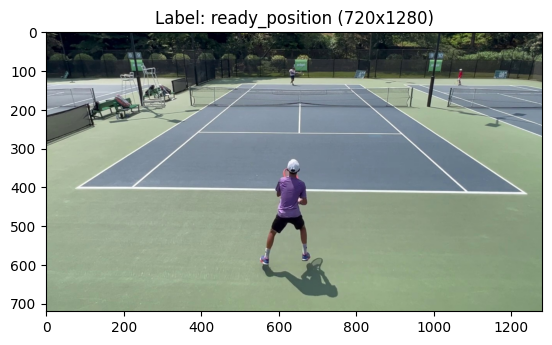

In [15]:
random_idx = random.randint(0, len(full_dataset.samples))
img = np.asarray(Image.open(full_dataset.samples[random_idx][0]))
label_idx = full_dataset.samples[random_idx][1]
label = [label for label, idx in label_to_idx.items() if idx == label_idx]

plt.imshow(img)
plt.title(f"Label: {label[0]} ({img.shape[0]}x{img.shape[1]})")
plt.show()

We observe that all images have (720x1280) resolution, we will have to deal with this later since big image sizes require more computing resources. We also check the four different types of labels we have: **forehand**, **backhand**, **ready_position** and **serve**. 

Next, we will divide the dataset into training, testing and validation. Moreover, we will apply some transformations to the data. Firstly, for all datasets we will **scale** them by using the precomputed mean and variance of each channel. Next, we will **resize** the images from (720x1280) to (240x240). This is because dealing with high resolution images takes lots of computing, and we could distinguish by eye-balling these classes even with that resolution. In addition, since we will use later pre-trained and hand-made networks, we use this image size to have the same transformation for all of them and compare their results fairly. 

For the training set we will do some added transformations to help generalization. First, we will do a **horizontal flip** of the image 50% of the time. This makes sense when you take into account that there are left and right-handed players, therefore the model should not based a prediction on if the racket is on the left or right, but on the overall gesture. Also, we will add some random **rotation** of some degrees to capture variation in camera setup and make the classification more robust.

In [16]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        img = self.transform(img) if self.transform else img
        return img, label

    def __len__(self):
        return len(self.subset)

In [17]:
# Transform for testing and validation
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD),
    v2.Resize(IMG_SIZE)
])

# Transfrom for training
train_transform = v2.Compose([
    test_transform, 
    v2.RandomHorizontalFlip(),  # Default 50% probability
    v2.RandomRotation(degrees=MAX_DEGREES)
])

In [18]:
generator = torch.Generator().manual_seed(SEED)
train, test, val = random_split(full_dataset, DATA_SPLIT, generator=generator)

# Specific subsets
train = TransformSubset(train, train_transform)
test = TransformSubset(test, test_transform)
val = TransformSubset(val, test_transform)

# Loaders for fast accessing
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, BATCH_SIZE, shuffle=True)

print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")
print(f"Validation samples: {len(val)}")

Training samples: 1600
Testing samples: 200
Validation samples: 200


Now, let's check the training data after the transformations.

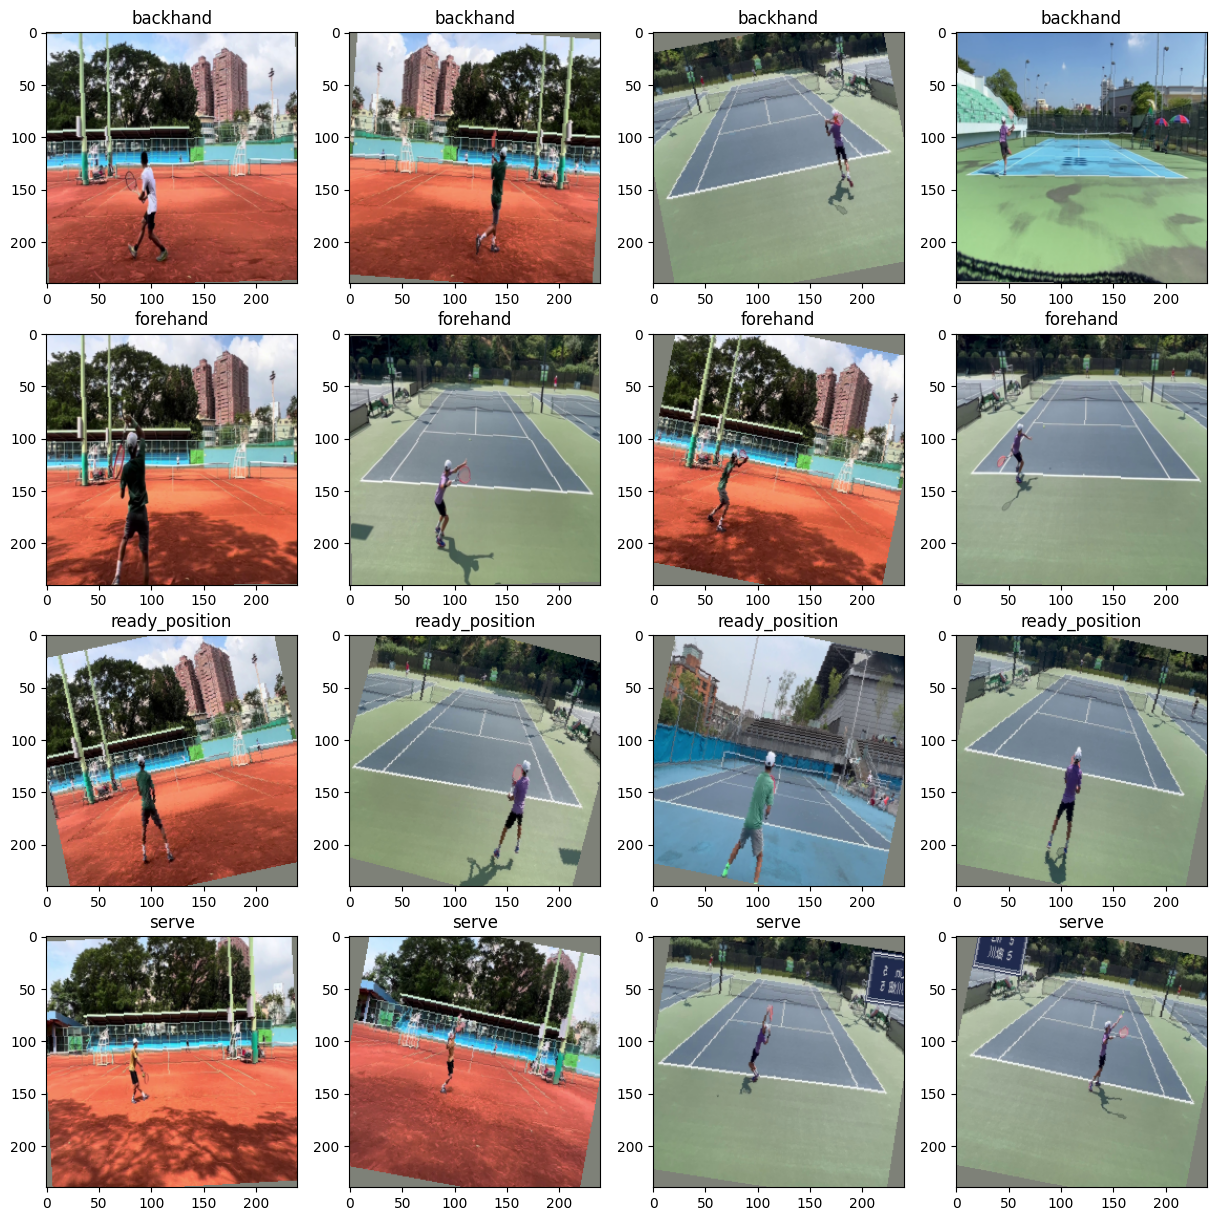

In [19]:
n_cols = 4
f, axarray = plt.subplots(len(label_to_idx), n_cols)
f.set_figheight(15)
f.set_figwidth(15)

for label in range(len(label_to_idx)):
    # Compute the class for the title 
    label_str = [l for l, idx in label_to_idx.items() if idx == label]

    for i in range(n_cols):
        # Get an image of that label
        l = len(label_to_idx) + 1
        while l != label: 
            random_idx = random.randint(0, len(train))
            img, l = train[random_idx]

        img = np.asarray(img).transpose(1, 2, 0)  # Change the channels from the first to last axis
        img = img * STD + MEAN  # Unnormalize
        img = np.clip(img.astype(int), 0, 255)  # Convert to int and clip between 0 and 255 for plotting

        # Assign images
        axarray[label, i].imshow(img)
        axarray[label, i].set_title(label_str[0])

We see that the transforms have been correct where we have random flips and some images are flipped if we check backhand and forehand.

Then, the next step is to build and train some models.

# **CLASSIFICATION**

## Training & Testing Loops

Before doing any classification with different models, we need to create a loop for training and testing these models easily. In addition, we will add a way to save the best models, some statistics with tensorboard and some early stopping to not train more epochs when overfitting. 

In [20]:
def train(train_loader, val_loader, loss_fn, optimizer, model, n_epochs, device, save_path=None, patience=3):
    """
    Trains a model and evaluates it in a provided validation set.
    """
    model.to(device)  # Send model to CPU/GPU
    best_val_loss = np.inf  # Best validation loss (main metric)
    bad_epochs = 0  # Number of epochs without improving loss

    for epoch in range(n_epochs): 
        # Training
        model.train()  # Set the model to training mode
        train_loss = 0
        train_acc = 0
        for batch, (data, labels) in enumerate(train_loader):
            # Send data and labels to CPU/GPU
            data = data.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Reset gradients
            preds = model(data)  # Predict training data
            loss = loss_fn(preds, labels)  # Calculate loss of the predictions
            loss.backward()  # Propagate the loss backwards
            optimizer.step()  # Update model parameters 

            batch_size = data.size(0) 
            train_loss += loss.item() * batch_size  # Multiply by batch size since loss is the mean
            train_acc += (preds.argmax(dim=1) == labels).sum().item()

        # Calculate loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_acc = 0
        with torch.no_grad():  # Disable gradients
            for batch, (data, labels) in enumerate(val_loader): 
                # Send data and labels to CPU/GPU
                data = data.to(device)
                labels = labels.to(device)
                preds = model(data)  # Predict validation data

                batch_size = data.size(0) 
                val_loss += loss_fn(preds, labels).item() * batch_size  # Multiply by batch size since loss is the mean
                preds = preds.argmax(dim=1)  # Get the class with highest probability
                val_acc += (preds == labels).sum().item()

        # Calculate loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)

        print(f"Epoch: {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f}; Train Accuracy: {train_acc:.3f} | \
                Validation Loss: {val_loss:.3f}; Validation Accuracy: {val_acc:.3f}")
        
        # Save the model if it has the lowest recorded loss
        if save_path and val_loss < best_val_loss:
            best_val_loss = val_loss
            bad_epochs = 0
            best_state = copy.deepcopy(model.state_dict())  # Using deepcopy to maintain best params even after training more epochs
            torch.save(model.state_dict(), save_path)
        else: 
            bad_epochs +=1

        # Early stopping if the model does not improve
        if bad_epochs > patience: 
            print(f"Early stopping at epoch {epoch+1}. Restoring best model (validation loss = {best_val_loss:.3f})")
            # Restore best model
            if best_state: 
                model.load_state_dict(best_state)
            break
        
        
        